# PANGAEA Model Testing Notebook

Use this notebook to evaluate a Pangaea model. To modify the behavior of this notebook, you can modify the corresponding .yaml file (found under ilab-pangaea-bench/configs), as well as the cells of the notebook. See the "global variables" section for some easily editable variables. 

## Building the environment

1) Find the `environment.yml` file in the repo, and executing the command: `conda env create -f environment.yml`. Make sure you are in the ilab-pangaea-repo directory that you've cloned!
2) In the jupyterhub session, click on the top right area that says `Python [...]`, and select `conda env: conda-pangaea-bench`.
3) You can now run the notebook as needed!

## Before you run
This notebook is designed to be run on a model that was trained using this repo, either using the training notebook or the CLI. 

## Setup

Import python packages, create and configure local directories, configure GPU acceleration, build logger, and set some global variables. 

**Note: if you want to change the functionality of this notebook, the Global Variables subsection is a good place to start.**

### Imports and clone repository

In [7]:
import os as os
from pathlib import Path
import pprint

import torch
from torch.nn.parallel import DistributedDataParallel
from hydra.utils import instantiate
from hydra import initialize, compose
from hydra import initialize_config_dir
from omegaconf import DictConfig, OmegaConf
from torch.utils.data import DataLoader
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torchmetrics.classification import JaccardIndex

import datetime
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import sys
import subprocess
import warnings

In [8]:
# Install albumentations
subprocess.check_call([sys.executable, "-m", "pip", "install", "albumentations"], 
                     stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL);

In [9]:
warnings.filterwarnings('ignore')
repo_name = "ilab-pangaea-bench"
if not os.path.exists(repo_name):
    subprocess.run(["git", "clone", "https://github.com/nasa-nccs-hpda/ilab-pangaea-bench.git"], 
                   check=True, stdout=subprocess.DEVNULL)
else:
    subprocess.run(["git", "-C", repo_name, "pull"], check=True, stdout=subprocess.DEVNULL)
sys.path.append("ilab-pangaea-bench")

In [10]:
from pangaea.decoders.base import Decoder
from pangaea.encoders.base import Encoder
from pangaea.utils.logger import init_logger
from pangaea.datasets.base import GeoFMDataset
from pangaea.utils.collate_fn import get_collate_fn
from pangaea.utils.eval_utils import (config_cuda, load_apply_ckpt, test_loop,
                                      plot_results_heatmap, plot_results_variable,
                                      plot_results_heatmap_2)

### Create and configure directories
These dictate where our outputs (logs, plots, etc) will be directed. A folder with the current date and time will be created.  

In [11]:
def make_experiment_dirs(datetime_str, base_dir="."):
    exp_dir = Path(base_dir) / datetime_str
    exp_dir.mkdir(exist_ok=True)
    logger_path = exp_dir / "test.log"

    return exp_dir, logger_path

In [12]:
datetime_str = datetime.datetime.now().strftime("%Y-%m-%d-%H:%M")
exp_dir, logger_path = make_experiment_dirs(datetime_str, ".")

### Global Variables
These will affect the rest of the notebook, change them for your individual task. For example, if you wish to create your own .yaml file to run this notebook, change the `config_name` variable below. 

In [13]:
# Where to create the working directory for this notebook
working_dir = exp_dir  # Default is to use exp_dir for everything

# Plotting path information
heatmap_plot_filename = f"heatmap"
second_plot_filename = f"plot_2"

# How much info the logger will display; 0 means no logging, 1 means minimal logging, 2 means extra logging detail
logger_verbosity = 0

# This creates a directory where we will load our trained model checkpoint
ckpt_path = "/explore/nobackup/people/ajkerr1/EO_FM/ex_train_dir"
experiment_dir = "20250820_223702_51278d_terramind_landsat_large_seg_upernet_landsatnlcd_7band"
ckpt_dir = Path(ckpt_path, experiment_dir)

# This can be left as the empty string, "", if your test data is in the same directory as training data
# Otherwise, this notebook will try to evaluate using the same data used to train the model checkpoint
test_data_dir = ("/explore/nobackup/people/mfrost2/lscratch"
                 "/EO_FM/data/Landsat_NLCD_data_agg5/test")

# Where we will load our hydra config from
config_path = str(ckpt_dir / "configs" / "config.yaml")

### Configure Hydra
This allows us to run a test using the .yaml framework from Pangaea.

In [14]:
# Init Hydra from config
with initialize_config_dir(config_dir=config_path, version_base=None):
    cfg = OmegaConf.load(config_path)

print("Config loaded successfully!")

Config loaded successfully!


#### Editing config to use test dataset

In [15]:
cfg["dataset"]["root_path"] = test_data_dir
cfg.train = False

### Configure CUDA for GPU acceleration
We need this to run our notebook on a GPU.

In [16]:
device, local_rank, world_size = config_cuda(cfg, backend="nccl")

Single GPU training detected, skipping distributed init.


### Build logger

This provides some debugging information on various processes.

In [17]:
def build_logger(cfg, logger_path, exp_dir, device, rank=local_rank):
    logger = init_logger(logger_path, rank=rank)
    if (logger_verbosity > 0):
        logger.info("============ Initialized logger ============")
        if (logger_verbosity > 1):
            logger.info(pprint.pformat(OmegaConf.to_container(cfg), compact=True).strip("{}"))
        logger.info("The experiment is stored in %s\n" % exp_dir)
    return logger

In [18]:
logger = build_logger(cfg, logger_path, exp_dir, device, local_rank)

## Build Model

### Initialize encoder/decoder before loading checkpoint

In [19]:
def build_encoder(cfg, logger):
    encoder: Encoder = instantiate(cfg.encoder)
    encoder.load_encoder_weights(logger)
    logger.info(f"Built {encoder.model_name}, using weights from: {cfg.encoder.download_url}")
    return encoder

def build_decoder(cfg, encoder, device, logger):
    decoder: Decoder = instantiate(
        cfg.decoder,
        encoder=encoder,
    )
    decoder.to(device)
    decoder_name = cfg.decoder._target_.split(".")[-1]
    logger.info(f"Built {decoder_name} decoder.")

    return decoder

In [20]:
# Model operations in Pangaea require a logger
encoder = build_encoder(cfg, logger)
# Pangaea wraps encoder and decoder into one Decoder type
encoder_decoder = build_decoder(cfg, encoder, device, logger)

# Final model is built using distributed GPU resources if we have more than 1 GPU
if (world_size > 1):
    model = DistributedDataParallel(
        encoder_decoder,
        device_ids=[local_rank],
        output_device=local_rank,
        find_unused_parameters=cfg.finetune,
    )

/home/ajkerr1/.conda/envs/pangaea-bench/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO - 09/09/25 14:37:33 - 0:00:05 - Loading encoder weights from ./pretrained_models/TerraMind_v1_large.pt
INFO - 09/09/25 14:37:50 - 0:00:22 - Mapped band 0 -> 0 for encoder_embeddings.untok_sen2l2a@224.proj.weight
INFO - 09/09/25 14:37:50 - 0:00:22 - Mapped band 1 -> 1 for encoder_embeddings.untok_sen2l2a@224.proj.weight
INFO - 09/09/25 14:37:50 - 0:00:22 - Mapped band 2 -> 2 for encoder_embeddings.untok_sen2l2a@224.proj.weight
INFO - 09/09/25 14:37:50 - 0:00:22 - Mapped band 3 -> 3 for encoder_embeddings.untok_sen2l2a@224.proj.weight
INFO - 09/09/25 14:37:50 - 0:00:22 - Mapped band 8 -> 4 for encoder_embeddings.untok_sen2l2a@224.proj.weight
INFO - 09/09/25 14:37:50 - 0:00:22 - Mapped band 10 -> 5 for encoder_embe

### Load model checkpoint from path

In [21]:
model = load_apply_ckpt(ckpt_dir, device, encoder_decoder, logger, logger_verbosity)

## Load test data, run through model

### Get Dataloader
From our config file, we can build a dataset which is then served in batches by the PyTorch DataLoader.

In [22]:
def get_dataloader(cfg, encoder, logger):
    # Preprocessor is required by dataset class
    test_preprocessor = instantiate(
        cfg.preprocessing.test,
        dataset_cfg=cfg.dataset,
        encoder_cfg=cfg.encoder,
        _recursive_=False,
    )

    # Create dataset
    raw_test_dataset = instantiate(cfg.dataset, split="test")
    test_dataset = GeoFMDataset(raw_test_dataset, test_preprocessor)

    # Create batches by modality using collate function
    modalities = list(encoder.input_bands.keys())
    collate_fn = get_collate_fn(modalities)

    # Dataloader from dataset
    test_loader = DataLoader(
        test_dataset,
        batch_size=32,  # Change this to a larger size if desired
        num_workers=4,  # Change this to a larger number if desired
        pin_memory=True,
        collate_fn=collate_fn
    )

    if (logger_verbosity > 1):
        logger.info(f"Built dataloader from dataset: {cfg.dataset.dataset_name}")
        logger.info(f"Dataset gathered files from: {cfg.dataset.root_path}")

    return test_loader

In [23]:
test_loader = get_dataloader(cfg, encoder, logger)

Found 1418 paired image-label files in /explore/nobackup/people/mfrost2/lscratch/EO_FM/data/Landsat_NLCD_data_agg5/test/images


### Perform forward pass of model on test dataset
Using the test dataloader, we can get model predictions on test inputs.

In [24]:
logger.info("Beginning test loop...")
test_dict = test_loop(cfg, model, device, test_loader, logger)
logger.info("Testing complete.")

INFO - 09/09/25 14:37:55 - 0:00:27 - Beginning test loop...
Test loop:   2%|▏         | 1/45 [00:13<10:10, 13.87s/it]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:   4%|▍         | 2/45 [00:14<04:19,  6.03s/it]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:   7%|▋         | 3/45 [00:14<02:28,  3.53s/it]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:   9%|▉         | 4/45 [00:15<01:36,  2.35s/it]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  11%|█         | 5/45 [00:16<01:07,  1.70s/it]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  13%|█▎        | 6/45 [00:16<00:50,  1.31s/it]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  16%|█▌        | 7/45 [00:17<00:40,  1.05s/it]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  18%|█▊        | 8/45 [00:17<00:33,  1.12it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  20%|██        | 9/45 [00:18<00:28,  1.27it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  22%|██▏       | 10/45 [00:18<00:24,  1.40it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  24%|██▍       | 11/45 [00:19<00:22,  1.51it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  27%|██▋       | 12/45 [00:19<00:20,  1.59it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  29%|██▉       | 13/45 [00:20<00:19,  1.65it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  31%|███       | 14/45 [00:20<00:18,  1.70it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  33%|███▎      | 15/45 [00:21<00:17,  1.73it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  36%|███▌      | 16/45 [00:22<00:16,  1.76it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  38%|███▊      | 17/45 [00:22<00:15,  1.78it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  40%|████      | 18/45 [00:23<00:15,  1.79it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  42%|████▏     | 19/45 [00:23<00:14,  1.80it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  44%|████▍     | 20/45 [00:24<00:13,  1.80it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  47%|████▋     | 21/45 [00:24<00:13,  1.81it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  49%|████▉     | 22/45 [00:25<00:12,  1.81it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  51%|█████     | 23/45 [00:25<00:12,  1.81it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  53%|█████▎    | 24/45 [00:26<00:11,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  56%|█████▌    | 25/45 [00:27<00:11,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  58%|█████▊    | 26/45 [00:27<00:10,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  60%|██████    | 27/45 [00:28<00:09,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  62%|██████▏   | 28/45 [00:28<00:09,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  64%|██████▍   | 29/45 [00:29<00:08,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  67%|██████▋   | 30/45 [00:29<00:08,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  69%|██████▉   | 31/45 [00:30<00:07,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  71%|███████   | 32/45 [00:30<00:07,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  73%|███████▎  | 33/45 [00:31<00:06,  1.82it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  76%|███████▌  | 34/45 [00:31<00:05,  1.84it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  78%|███████▊  | 35/45 [00:32<00:05,  1.86it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  80%|████████  | 36/45 [00:33<00:04,  1.87it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  82%|████████▏ | 37/45 [00:33<00:04,  1.87it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  84%|████████▍ | 38/45 [00:34<00:03,  1.88it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  87%|████████▋ | 39/45 [00:34<00:03,  1.88it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  89%|████████▉ | 40/45 [00:35<00:02,  1.88it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  91%|█████████ | 41/45 [00:35<00:02,  1.88it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  93%|█████████▎| 42/45 [00:36<00:01,  1.89it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  96%|█████████▌| 43/45 [00:36<00:01,  1.89it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop:  98%|█████████▊| 44/45 [00:37<00:00,  1.89it/s]

preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))


Test loop: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]
INFO - 09/09/25 14:38:37 - 0:01:09 - metric IoU average over all eval samples: 0.36089441180229187


preds, targets devices: (device(type='cuda', index=0), device(type='cuda', index=0))
targets shape: (1418, 224, 224)
preds shape: (1418, 224, 224)


INFO - 09/09/25 14:38:38 - 0:01:10 - Testing complete.


images shape: (1418, 7, 1, 224, 224)


## Visualize model performance on test set

### Plot targets vs predictions heatmap
This plots the first 5 targets and predictions alongside one another.

INFO - 09/09/25 14:38:38 - 0:01:10 - Creating heatmap and saving to png...


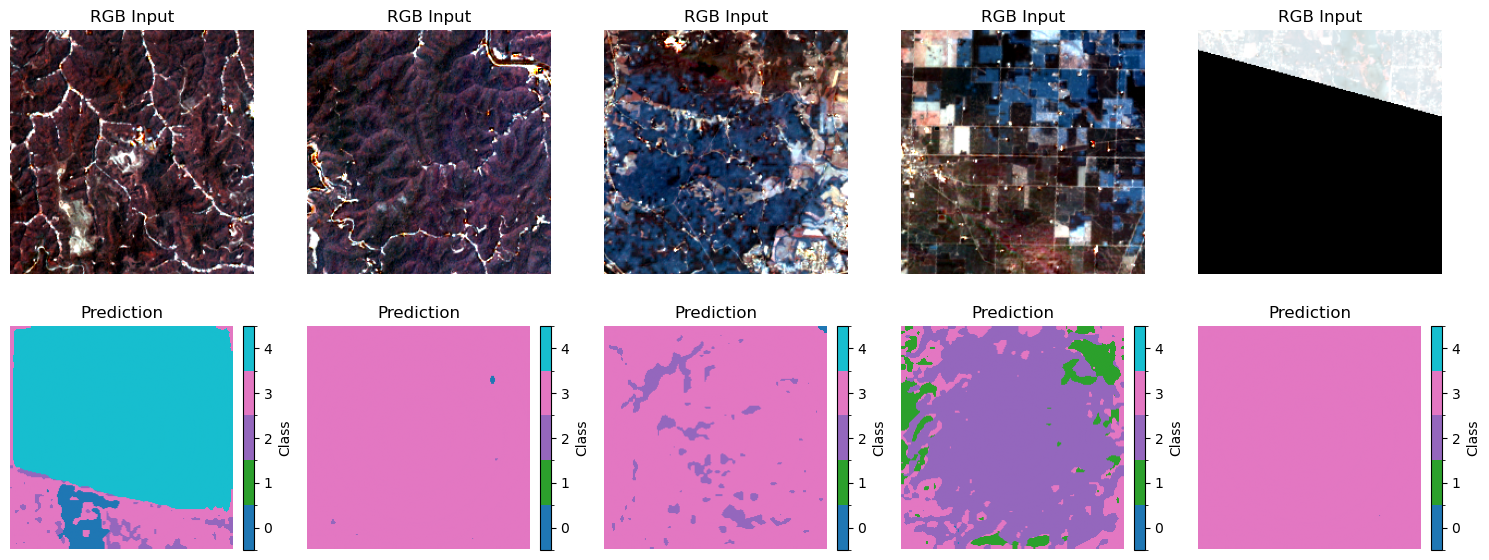

In [25]:
logger.info("Creating heatmap and saving to png...")

fig = plot_results_heatmap_2(
    cfg=cfg,
    targets=test_dict["targets"],
    preds=test_dict["preds"],
    images=test_dict["images"],
    save_dir=working_dir,
    png_prefix=heatmap_plot_filename,
)
plt.show()
plt.close()

### Create second eval plot
This plot will be different depending on the model task. Classification and regression models will show a scatter plot depicting the closeness of predictions and targets (more symmetrical across the diagonal means better predictions). Segmentation models will display a confusion matrix.

INFO - 09/09/25 14:38:40 - 0:01:12 - Creating eval plot and saving to png...


R² calculated directly: 0.1119
Generating normalized confusion matrix...


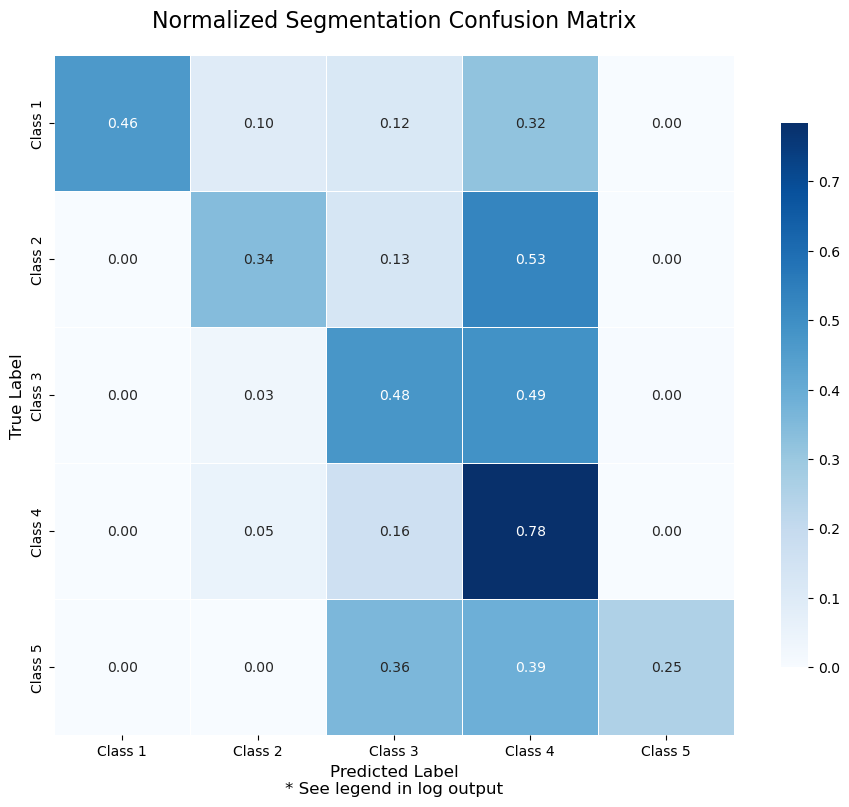


Classification Report:
              precision    recall  f1-score   support

     Class 1       0.83      0.46      0.59    618783
     Class 2       0.55      0.34      0.42  10185537
     Class 3       0.50      0.48      0.49  17818670
     Class 4       0.70      0.78      0.74  42348909
     Class 5       0.36      0.25      0.30    177669

    accuracy                           0.64  71149568
   macro avg       0.59      0.46      0.51  71149568
weighted avg       0.63      0.64      0.63  71149568



In [26]:
logger.info("Creating eval plot and saving to png...")

fig, val_df = plot_results_variable(
    cfg=cfg,
    targets=test_dict["targets"],
    predictions=test_dict["preds"],
    save_dir=working_dir,
    png_prefix=second_plot_filename
)
plt.show()
plt.close()